In [83]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
    
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
import easing
from collections import Counter
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

sys.path.append('../Utility_Scripts/')
from synthetic_data_generator import MLR,meal_income,two_feature_uncertainty
from ensemble_methods import EnsembleModel
import matplotlib.patches as mpatches
from training_on_uncertainty import PCA_binning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# load ML packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy import array
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,StratifiedKFold,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
from matplotlib.patches import Rectangle as rec
from easing import easing


In [85]:
# set reproducable values
seed_value= 88

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)



![fig](../media/training_uncertainty_schema.png)
This approach to UQ relies on having a model explicity trained to predict the uncertainty in a value, not simply the vairance around its predictions. 

# Basic analysis : Linear Regression trained to predict value and uncertainty simultaneously (2 outputs) // manual binning
![fig](figures/binned_example.png)

See code below for figure generation


In [86]:
%%capture
meal_income_df=meal_income(size=1000,return_df=True)
colors_h=sns.color_palette("husl", 2)
colors_r=sns.color_palette("rainbow", 2)


###plotting emperical data
fig,ax=plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
ax[0].scatter(meal_income_df['X'],meal_income_df['y'],color='#d3d3d3')
bins=np.append(np.arange(0,100,10),100)
for b in bins:
    ax[0].plot([b,b],[0,100],color='black')
ax[0].set_title('Emperical Data \n (binned)')
ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Normalized Cost of Last Meal')



### binning data
X_y_df=meal_income_df[['X','y']]
X_y_df.loc[:,'bins']=np.digitize(X_y_df.X, bins, right=True)
Binned_df=X_y_df.groupby('bins').mean().rename(columns={'X':'X_mean','y':'y_mean'})
Binned_df.loc[:,'y_std']=X_y_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']

ax[1].errorbar(Binned_df['X_mean'],Binned_df['y_mean'],yerr=Binned_df['y_std'],fmt='o',color=colors_h[0],ecolor=colors_h[1])
ax[1].set_title('Summary Statistics of \n Binned Data')
recs=[]
for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors_h[j]))
ax[1].legend(recs, ['Mean y value','STD y value'], loc='upper right')
ax[1].set_xlabel('Normalized Annual Income')
ax[1].set_ylabel('Normalized Cost of Last Meal')
fig.savefig('figures/binned_example.png',bbox_inches='tight',dpi=300)



# training a model on this

In [87]:
# generating and splitting data
meal_income_df=meal_income(size=1000,return_df=True)   
Train, test = train_test_split(meal_income_df, test_size=0.1,random_state=88)

### convert training data into learnable uncertainty
X_y_df=Train[['X','y']]
X_y_df.loc[:,'bins']=np.digitize(X_y_df.X, np.arange(100)+1, right=True)

Binned_df=X_y_df.groupby('bins').mean().rename(columns={'X':'X_mean','y':'y_mean'})
Binned_df.loc[:,'y_std']=X_y_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']

In [88]:
model = LinearRegression()
X=Binned_df.X_mean.values.reshape(-1, 1)
y=Binned_df[['y_mean','y_std']].values
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
predicted_values=model.predict(test['X'].values.reshape(-1,1))

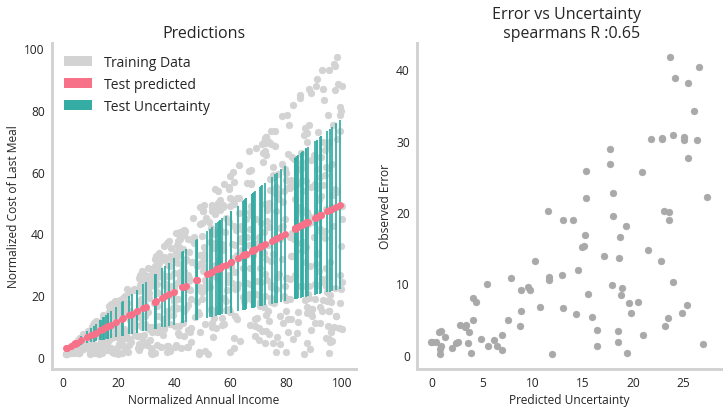

In [91]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(Train['X'].ravel(),Train['y'].ravel(),color='#d3d3d3')

ax[0].errorbar(test['X'].values,predicted_values[:,0],yerr=predicted_values[:,1],fmt='o',color=colors_h[0],ecolor=colors_h[1])


recs=[mpatches.Rectangle((0, 0), 1, 1, fc='#d3d3d3')]
for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors_h[j]))
ax[0].legend(recs, ['Training Data','Test predicted','Test Uncertainty'], loc='upper left')
ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Normalized Cost of Last Meal')
ax[0].set_title('Predictions')

errors=abs(test['y'].values-predicted_values[:,0])

ax[1].scatter(predicted_values[:,1],errors,color='darkgrey')
ax[1].set_xlabel('Predicted Uncertainty')
ax[1].set_ylabel('Observed Error')
corr=spearmanr(predicted_values[:,1],errors)[0]
ax[1].set_title(f'Error vs Uncertainty \n spearmans R :{np.round(corr,2)}')


fig.savefig('figures/test_train_singlefeat.png',bbox_inches='tight',dpi=300)


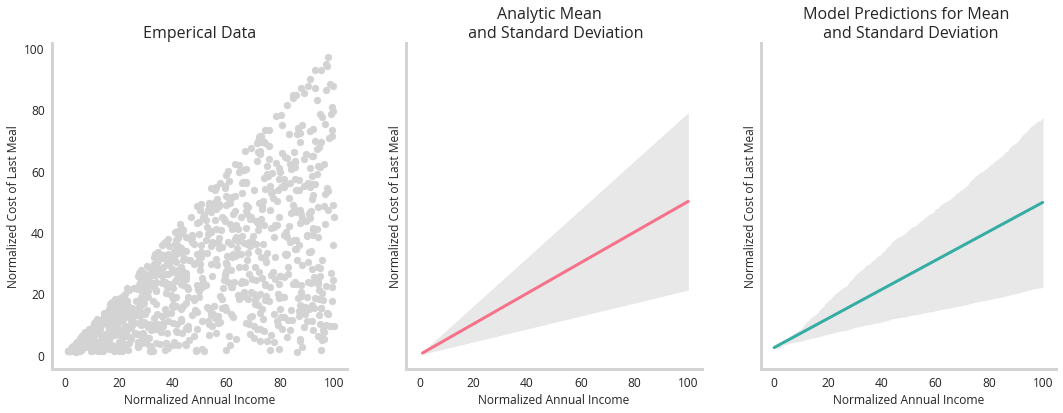

In [75]:
fig,ax=plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
ax[0].scatter(meal_income_df['X'].ravel(),meal_income_df['y'].ravel(),color='#d3d3d3')


x_values=meal_income_df['X']
mu=meal_income_df['mu']
sigma=meal_income_df['sigma']

ax[1].plot(x_values.ravel(), mu,linewidth=3,color=colors_h[0])
ax[1].fill_between(x_values.ravel(), mu - sigma, mu + sigma, alpha=0.5,color='#d3d3d3')

x_vect=np.linspace(0,100,1000).reshape(-1,1)
predicted_values=model.predict(x_vect)
ax[2].plot(x_vect, predicted_values[:,0],linewidth=3,color=colors_h[1])

minus_std=predicted_values[:,0]-predicted_values[:,1]
plus_std=predicted_values[:,0]+predicted_values[:,1]

ax[2].fill_between(x_values.ravel(),minus_std,plus_std , alpha=0.5,color='#d3d3d3')

ax[0].set_title('Emperical Data')
ax[1].set_title('Analytic Mean  \n and Standard Deviation')
ax[2].set_title('Model Predictions for Mean \n and Standard Deviation')

for r in range(3):
    ax[r].set_xlabel('Normalized Annual Income')
    ax[r].set_ylabel('Normalized Cost of Last Meal')
fig.savefig('figures/analytic_v_emperical.png',bbox_inches='tight',dpi=300)


# Multiple Feature Dimensions and More powerful models
![fig](../media/mulitin_multiout.png)


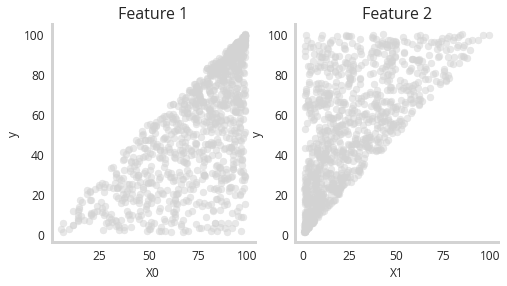

In [55]:
### consider a dataset with two features with different noise profiles 

two_feat_df=two_feature_uncertainty(size=1000)

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(two_feat_df['X0'],two_feat_df['y'],color='#d3d3d3',alpha=0.5)
ax[1].scatter(two_feat_df['X1'],two_feat_df['y'],color='#d3d3d3',alpha=0.5)

ax[0].set_xlabel('X0')
ax[1].set_xlabel('X1')
ax[0].set_ylabel('y')
ax[1].set_ylabel('y')
ax[0].set_title('Feature 1')
ax[1].set_title('Feature 2')
fig.savefig('figures/two_feature_space.png',bbox_inches='tight',dpi=300)


In [56]:
# Multiple X dimensions
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA

In [57]:
## binning data according to PCA
pca = PCA(n_components=1)
two_feat_df['PCA_values']=pca.fit_transform(two_feat_df[['X0','X1']])
bins=np.linspace(min(two_feat_df['PCA_values']),max(two_feat_df['PCA_values']),100)
two_feat_df['bins']=np.digitize(two_feat_df['PCA_values'], bins=bins, right=True)

Binned_df=two_feat_df.groupby('bins').mean().rename(columns={'X0':'X0_mean','y':'y_mean','X1':'X1_mean'})
Binned_df.loc[:,'y_std']=two_feat_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']



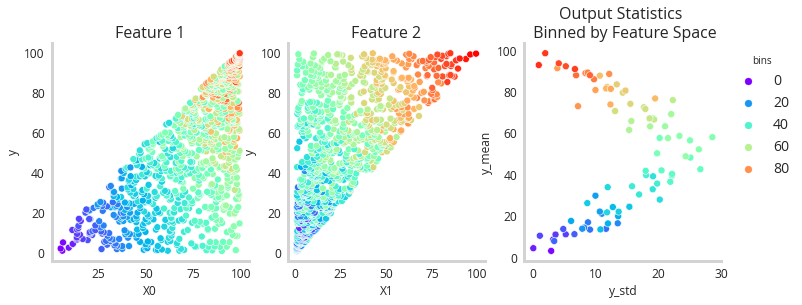

In [58]:
# plotting binned data
fig,ax=plt.subplots(1,3,figsize=(12,4))

sns.scatterplot(x='X0',y='y',hue='bins',data=two_feat_df,ax=ax[0],palette='rainbow')
sns.scatterplot(x='X1',y='y',hue='bins',data=two_feat_df,ax=ax[1],palette='rainbow')
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)


sns.scatterplot(x='y_std',y='y_mean',hue='bins',data=Binned_df.reset_index(),ax=ax[2],palette='rainbow')
ax[2].legend(bbox_to_anchor=(1, 1),title='bins')
ax[0].set_title('Feature 1')
ax[1].set_title('Feature 2')
ax[2].set_title('Output Statistics \n Binned by Feature Space')
fig.savefig('figures/PCA_featurespace.png',bbox_inches='tight',dpi=300)


In [59]:
# building a model to predict this uncertainty?

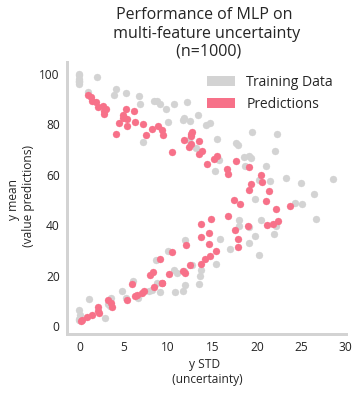

In [60]:


def build_multi_out_MLP(in_dim,out_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=in_dim, activation="relu"))
    model.add(Dense(128, input_dim=in_dim, activation="relu"))
    model.add(Dense(64, input_dim=in_dim, activation="relu"))
    model.add(Dense(out_dim))
    model.compile(loss="mse", optimizer="adam")
    return model


Binned_df=Binned_df.fillna(0)
X=Binned_df[['X0_mean','X1_mean']].values
y=Binned_df[['y_mean','y_std']].values
in_dim = X.shape[1]
out_dim = y.shape[1]


model=build_multi_out_MLP(in_dim,out_dim)
model.fit(X, y, epochs=100, batch_size=1, verbose=0)
predicted_values=model.predict(X)
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(Binned_df['y_std'],Binned_df['y_mean'],color='#d3d3d3')

ax.scatter(predicted_values[:,1],predicted_values[:,0],color=colors_h[0])

sub_colors=['#d3d3d3',colors_h[0]]
recs=[]
for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=sub_colors[j]))
ax.legend(recs, ['Training Data','Predictions'], bbox_to_anchor=(1, 1))

ax.set_xlabel('y STD \n (uncertainty)')
ax.set_ylabel('y mean \n (value predictions)')
ax.set_title('Performance of MLP on \n multi-feature uncertainty \n (n=1000)')
fig.savefig('figures/MLP_performance_1000.png',bbox_inches='tight',dpi=300)


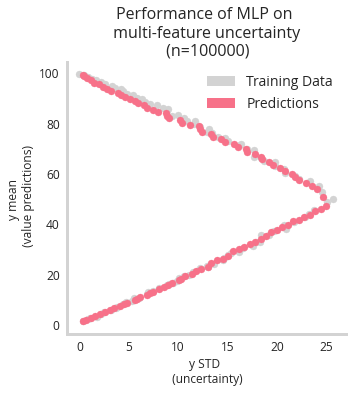

In [61]:
# n=100000
two_feat_df=two_feature_uncertainty(size=100000)
pca = PCA(n_components=1)
two_feat_df['PCA_values']=pca.fit_transform(two_feat_df[['X0','X1']])
bins=np.linspace(min(two_feat_df['PCA_values']),max(two_feat_df['PCA_values']),100)
two_feat_df['bins']=np.digitize(two_feat_df['PCA_values'], bins=bins, right=True)

Binned_df=two_feat_df.groupby('bins').mean().rename(columns={'X0':'X0_mean','y':'y_mean','X1':'X1_mean'})
Binned_df.loc[:,'y_std']=two_feat_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']
Binned_df=Binned_df.fillna(0)
X=Binned_df[['X0_mean','X1_mean']].values
y=Binned_df[['y_mean','y_std']].values
in_dim = X.shape[1]
out_dim = y.shape[1]
model.fit(X, y, epochs=100, batch_size=1, verbose=0)
model=build_multi_out_MLP(in_dim,out_dim)
model.fit(X, y, epochs=100, batch_size=1, verbose=0)
predicted_values=model.predict(X)
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(Binned_df['y_std'],Binned_df['y_mean'],color='#d3d3d3')

ax.scatter(predicted_values[:,1],predicted_values[:,0],color=colors_h[0])

sub_colors=['#d3d3d3',colors_h[0]]
recs=[]
for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=sub_colors[j]))
ax.legend(recs, ['Training Data','Predictions'], bbox_to_anchor=(1, 1))

ax.set_xlabel('y STD \n (uncertainty)')
ax.set_ylabel('y mean \n (value predictions)')
ax.set_title('Performance of MLP on \n multi-feature uncertainty \n (n=100000)')
fig.savefig('figures/MLP_performance_100000.png',bbox_inches='tight',dpi=300)


# Real World Example

In [93]:
from sklearn.datasets import load_boston
X_boston, y_boston = load_boston(return_X_y=True)

X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(X_boston, y_boston, test_size=0.1, random_state=88)



boston_df=pd.DataFrame(X_dataset)
feature_cols=list(boston_df.columns)
boston_df['y']=y_dataset

In [94]:
pca = PCA(n_components=1)
boston_df['PCA_values']=pca.fit_transform(boston_df[feature_cols])

bins=np.linspace(min(boston_df['PCA_values']),max(boston_df['PCA_values']),300)
boston_df['bins']=np.digitize(boston_df['PCA_values'], bins=bins, right=True)

Binned_df=boston_df.groupby('bins').mean().rename(columns={'y':'y_mean'})
Binned_df.loc[:,'y_std']=boston_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']
Binned_df=Binned_df.fillna(0)

In [95]:
# training model
X=Binned_df[feature_cols].values
y=Binned_df[['y_mean','y_std']].values
in_dim = X.shape[1]
out_dim = y.shape[1]

#LGBM regressor
model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=88))
model.fit(X, y)



MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=88, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                                             subsample_for_bin=200000,
                     

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


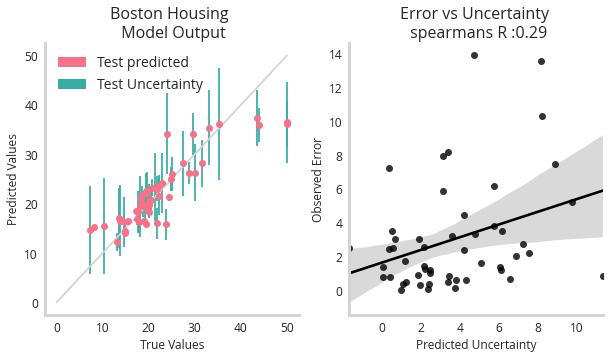

In [99]:
# Testing on holdout set
fig,ax=plt.subplots(1,2,figsize=(10,5))

predictions=model.predict(X_holdout)

#ax.scatter(Binned_df['y_std'],Binned_df['y_mean'],color='#d3d3d3')
ax[0].errorbar(y_holdout,predictions[:,0],yerr=predictions[:,1],fmt='o',color=colors_h[0],ecolor=colors_h[1])
ax[0].plot([0,50],[0,50],color='#d3d3d3')
recs=[]
for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors_h[j]))
ax[0].legend(recs, ['Test predicted','Test Uncertainty'], loc='upper left')

ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Boston Housing \n Model Output')

#ax[1].scatter(predictions[:,1],abs(y_holdout-predictions[:,0]))
sns.regplot(predictions[:,1],abs(y_holdout-predictions[:,0]),ax=ax[1],color='black')

ax[1].set_xlabel('Predicted Uncertainty')
ax[1].set_ylabel('Observed Error')

corr=spearmanr(predictions[:,1],abs(y_holdout-predictions[:,0]))[0]
ax[1].set_title(f'Error vs Uncertainty \n spearmans R :{np.round(corr,2)}')


fig.savefig('figures/boston_trained_uncertainty.png',bbox_inches='tight',dpi=300)